In [ ]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn streamlit -q

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import xgboost as xgb


In [ ]:
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())  # Any nulls?


(7043, 21)
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Co

In [ ]:
# Remove rows with missing TotalCharges
df = df[df['TotalCharges'].notna()]
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    if col not in ['customerID', 'Churn']:
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# Encode target label
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Standardize numerical columns
scaler = StandardScaler()
df[['tenure', 'MonthlyCharges', 'TotalCharges']] = scaler.fit_transform(df[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [ ]:
# Tenure bucket
df['tenure_bucket'] = pd.cut(df['tenure'], bins=[-np.inf, -0.5, 0.5, np.inf], labels=['Short', 'Medium', 'Long'])
df['tenure_bucket'] = LabelEncoder().fit_transform(df['tenure_bucket'].astype(str))

# Engagement
df['engagement_ratio'] = df['MonthlyCharges'] / (df['tenure'] + 1)

# Complaint rate stub (not in dataset, placeholder):
df['complaint_rate'] = 0

# Drop unused columns
df = df.drop(['customerID'], axis=1)


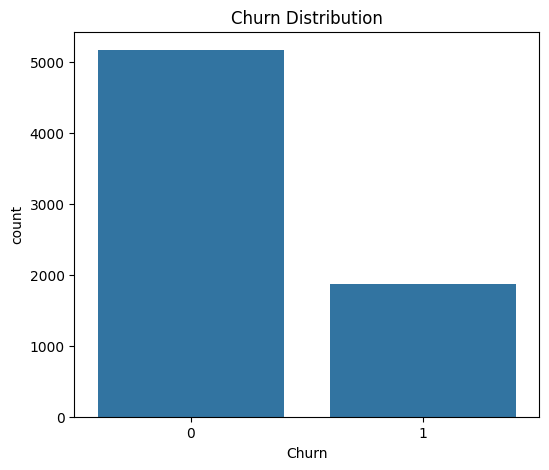

In [ ]:
plt.figure(figsize=(6, 5))
sns.countplot(data=df, x='Churn')
plt.title('Churn Distribution')
plt.show()

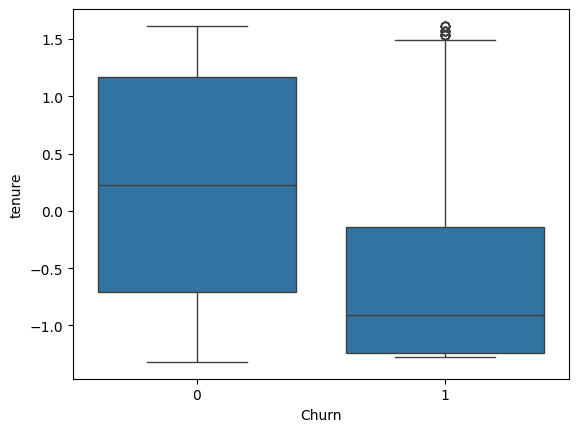

In [ ]:
sns.boxplot(data=df, x='Churn', y='tenure')
plt.show()

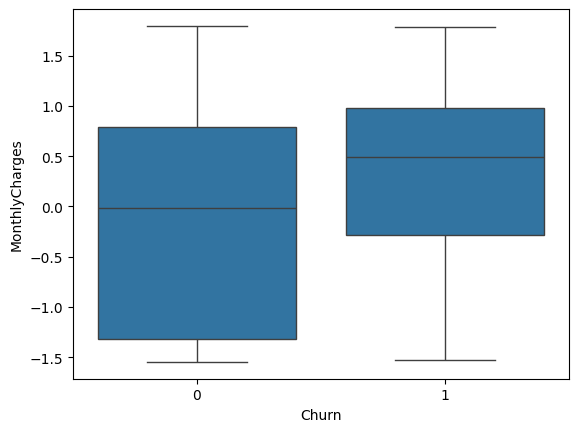

In [ ]:
sns.boxplot(data=df, x='Churn', y='MonthlyCharges')
plt.show()

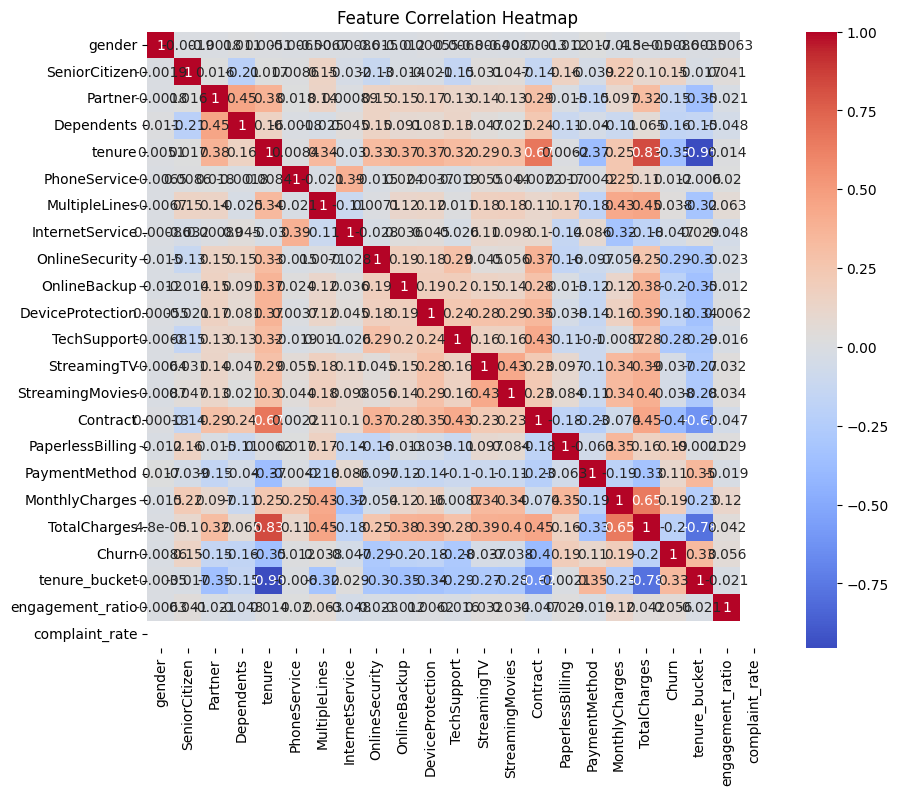

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

In [ ]:
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [08:42:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [ ]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print('F1:', f1_score(y_test, y_pred))
print('ROC-AUC:', roc_auc_score(y_test, y_prob))
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))


Accuracy: 0.7955997161107168
Precision: 0.639344262295082
Recall: 0.5227882037533512
F1: 0.5752212389380531
ROC-AUC: 0.843531007069881
Confusion Matrix:
 [[926 110]
 [178 195]]


In [ ]:
import pickle
pickle.dump(model, open('xgb_churn_model.pkl', 'wb'))

In [ ]:
from google.colab import files

files.download('xgb_churn_model.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# dashboard.py
import streamlit as st
import pandas as pd
import pickle

st.title('Customer Churn Prediction Dashboard')
model = pickle.load(open('xgb_churn_model.pkl', 'rb'))

file = st.file_uploader('Upload customer CSV', type='csv')
if file:
    data = pd.read_csv(file)
    # Preprocess features here (same as above)
    # For simplicity, assume features already matched
    pred_prob = model.predict_proba(data)[:, 1]
    st.write(pd.DataFrame({'Churn Probability': pred_prob}))
    st.bar_chart(pred_prob)


2025-10-28 08:42:59.327 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 08:42:59.744 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-10-28 08:42:59.745 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 08:42:59.746 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 08:42:59.760 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 08:42:59.766 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 08:42:59.767 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-10-28 08:42:59.775 Thread 'MainThread': mi